In [1]:
from abc import ABCMeta
from abc import abstractmethod

class FileReader(metaclass = ABCMeta):
    @abstractmethod
    def read(self, file_name):
        pass

In [3]:
class TextFileReader(FileReader):
    def read(self, file_name):
        with open(file_name, 'r') as f:
            lines = f.read().splitlines()
        return lines

In [4]:
def get_cities_number(lines):
    return int(lines[0])

def get_edges_number(cities_number):
    return cities_number * (cities_number - 1) // 2

def get_edges(lines):
    edges = {}
    for i in range(1, len(lines)):
        line = lines[i]
        edge = line.split(" ")
        edges[edge[0]] = int(edge[1])
    return edges

def get_weights(lines):
#     edges = {}
#     for i in range(1, len(lines)):
#         line = lines[i]
#         edge = line.split(" ")
#         edges[edge[0]] = int(edge[1])
    edge = get_edges(lines)
    cities_number = get_cities_number(lines)
    for i in range(cities_number):
        edges[f"{i}{i}"] = 0
    return edges

In [5]:
def validate_citeis_number(cities_number):
    if 7 < cities_number:
        print("都市数が大きいです. もっと小さくしてください")
        return False
    elif cities_number < 1:
        print("入力値は1以上の整数です")
        return False
    return True

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

class Graph:
    def __init__(self, cities_number, edges_number):
        self.cities_number = cities_number
        self.edges_number = edges_number
    
    def get_cities_number(self):
        return self.cities_number
    
    def get_edges_number(self):
        return self.edges_number
    
    def get_graph(self, _edges):
        graph = nx.complete_graph(self.cities_number)
        for edge, weight in _edges.items():
            graph.edges[int(edge[0]), int(edge[1])]["weight"] = weight
        return graph
    
    def show(self, graph):
        pos = nx.spring_layout(graph)
        nx.draw(graph, pos, with_labels=True)
        labels = nx.get_edge_attributes(graph, 'weight')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
        plt.show()

以下のグラフの総移動コストが最小になるものを求めます.


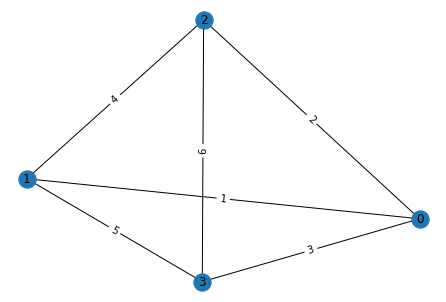

位相推定アルゴリズムのシミュレーション結果は以下のようになります.


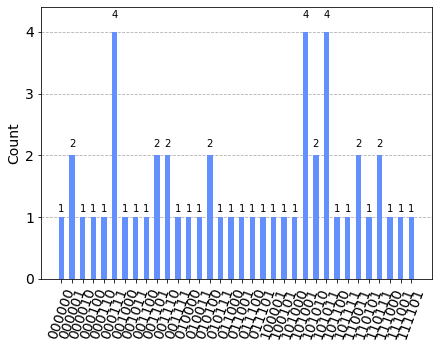

In [8]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit import BasicAer
from qiskit import ClassicalRegister
from qiskit import execute
from qiskit import IBMQ
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram

text_file = TextFileReader()

edges = get_edges(text_file.read("test.txt"))
N = get_cities_number(text_file.read("test.txt"))

print("以下のグラフの総移動コストが最小になるものを求めます.")
graph = Graph(N, get_edges_number(N))
graph.show(graph.get_graph(edges))

weights = get_weights(text_file.read("test.txt"))

def controlled_U(circ, a, b, c, d, n, k):
    circ.cp(c - a, q[n_ancilla - k], q[n_ancilla + n])
    circ.p(a, q[n_ancilla - k])
    circ.cp(b - a, q[n_ancilla - k], q[n_ancilla + n + 1])
    circ.ccx(q[n_ancilla - k], q[n_ancilla + n], q[n_ancilla + n + 1])
    circ.p(d + c - b - a, q[n_ancilla + n + 1])
    circ.ccx(q[n_ancilla - k], q[n_ancilla + n], q[n_ancilla + n + 1])

def qft_dagger(circ, q, n):
    for j in range(n):
        k = (n - 1) - j
        for m in range(k):
            circ.cp(- math.pi / float(2 ** (k - m)), q[k], q[m])
        circ.h(q[k])
        
def powered_controlled_U(circ, power):
    controlled_U(circ, weights["00"], weights["01"], weights["02"], weights["03"], 0, power)
    controlled_U(circ, weights["01"], weights["11"], weights["12"], weights["13"], 2, power)
    controlled_U(circ, weights["02"], weights["12"], weights["22"], weights["23"], 4, power)
    controlled_U(circ, weights["03"], weights["23"], weights["23"], weights["33"], 6, power)

n_ancilla = 6
n_eigenvector = 8
    
q = QuantumRegister(n_ancilla + n_eigenvector, 'q')
c = ClassicalRegister(n_ancilla, 'c')
qpe = QuantumCircuit(q, c)

qpe.h(q[n_ancilla])
qpe.h(q[n_ancilla + 1])
qpe.h(q[n_ancilla + 2])
qpe.h(q[n_ancilla + 3])
qpe.h(q[n_ancilla + 4])
qpe.h(q[n_ancilla + 5])
qpe.h(q[n_ancilla + 6])

for i in range(n_ancilla):
    qpe.h(q[i])
qpe.barrier()

powered_controlled_U(qpe, 1)
qpe.barrier()
for i in range(2):
    powered_controlled_U(qpe, 2)
qpe.barrier()
for i in range(4):
    powered_controlled_U(qpe, 3)
qpe.barrier()
for i in range(8):
    powered_controlled_U(qpe, 4)
qpe.barrier()
for i in range(16):
    powered_controlled_U(qpe, 5)
qpe.barrier()
for i in range(32):
    powered_controlled_U(qpe, 6)
qpe.barrier()

qft_dagger(qpe, q, 6)
qpe.barrier()
for i in range(n_ancilla):
    qpe.measure(q[i], c[i])

backend = BasicAer.get_backend('qasm_simulator')
shots = 50
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()
max_value = max(answer.items(), key = lambda x:x[1])
print("位相推定アルゴリズムのシミュレーション結果は以下のようになります.")
plot_histogram(answer)

In [8]:
ans = 0
two = 1
for char in reversed(max_value[0]):
    ans += int(char) * two
    two /= 2

print(f"求める最小総移動コストは{math.floor(2 * math.pi * ans)}です.")

求める最小総移動コストは10です.


下の巡回路が答えになります。


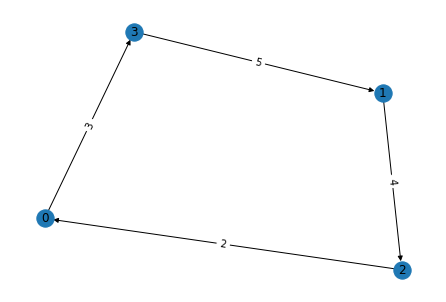

In [9]:
cost = math.floor(2 * math.pi * ans)
print("下の巡回路が答えになります。")
if abs(cost - 14) < abs(cost - 16):
    g = nx.DiGraph()
    g.add_node(0)
    g.add_node(1)
    g.add_node(2)
    g.add_node(3)
    g.add_weighted_edges_from([
        (0, 3, 3),
        (3, 1, 5), 
        (1, 2, 4),
        (2, 0, 2) 
    ])

    pos = nx.spring_layout(g)
    nx.draw(g, pos, with_labels=True)
    labels = nx.get_edge_attributes(g, 'weight')
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
    plt.show()
else:
    g = nx.DiGraph()
    g.add_node(0)
    g.add_node(1)
    g.add_node(2)
    g.add_node(3)
    g.add_weighted_edges_from([
        (0, 1, 1),
        (1, 2, 4), 
        (2, 3, 6),
        (3, 0, 5) 
    ])

    pos = nx.spring_layout(g)
    nx.draw(g, pos, with_labels=True)
    labels = nx.get_edge_attributes(g, 'weight')
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
    plt.show()

In [10]:
import itertools

def necklace_number(num):
    ans = 1
    for i in range(1, num):
        ans *= i
    return ans // 2

def get_all_connected_node_string(length):
    numbers = "".join([str(i) for i in range(length)])
    perms = []
    for v in itertools.permutations(numbers[1:]):
        perms.append(f"0{''.join(v)}0")
    return perms

def get_connected_node_string(length):
    numbers = "".join([str(i) for i in range(length)])
    perms = []
    for v in itertools.permutations(numbers[1:]):
        perms.append(f"0{''.join(v)}0")

    for i in range(len(perms)):
        if len(perms) == necklace_number(length):
            break
        perms.remove(perms[i][::-1])
    return perms
print(get_connected_node_string(4))

['01230', '01320', '02130']


In [11]:
import cv2
import math
from qiskit.visualization import plot_state_qsphere

def get_circuit_string(string):
    answer = ""
    for i in range(len(string) - 1):
        target = str(i)
        for j in range(len(string)):
            if target == string[j] and j > 0:
                answer += format(int(string[j - 1]), '02b')
                print(format(int(string[j-1]), "02b"))
    return answer

def binary_to_decimal(string):
    return int(string, 2)

# for string in get_connected_node_string(4):
#     print(get_circuit_string(string))

get_circuit_string("02130")

11
10
00
01


'11100001'

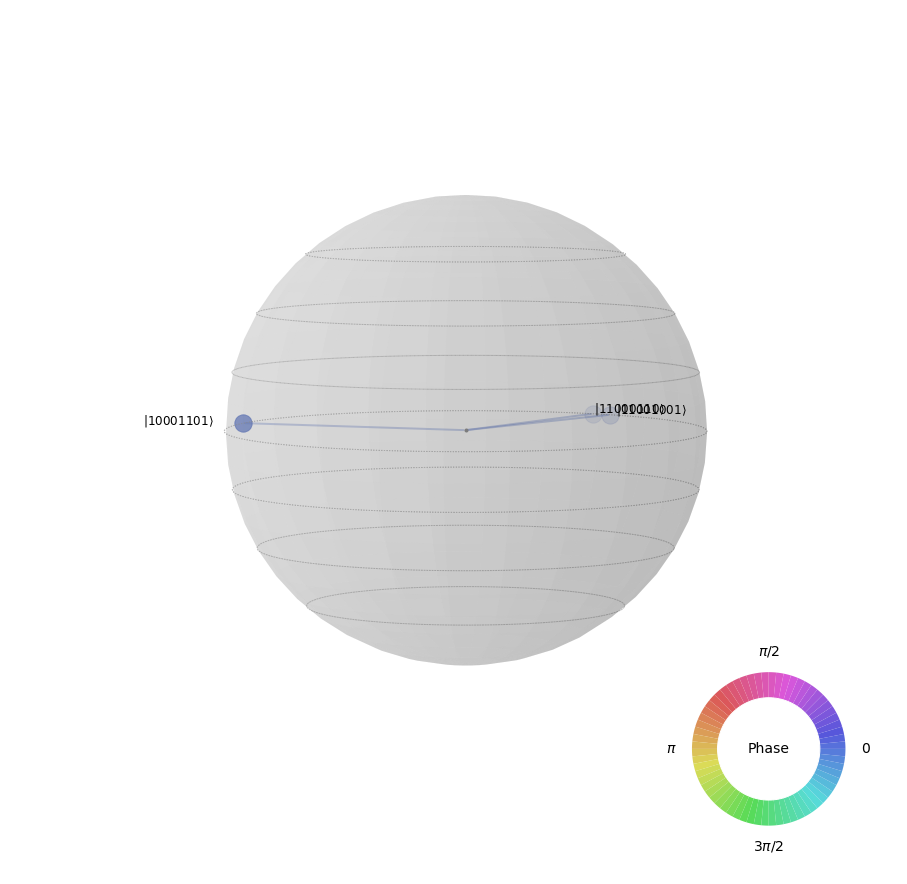

In [12]:
import matplotlib.pyplot as plt
import numpy as np

arr = [0] * 2 ** 8
arr[binary_to_decimal("10001101")] = 1 / math.sqrt(3)
arr[binary_to_decimal("11000110")] = 1 / math.sqrt(3)
arr[binary_to_decimal("11001001")] = 1 / math.sqrt(3)
plot_state_qsphere(arr, figsize=(16, 16))

In [7]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread("images/extends.png")

height = img.shape[0]
width = img.shape[1]
resized_img = cv2.resize(img,(round(width/2), round(height/2)))

cv2.imshow("Enlarged View", resized_img)

cv2.waitKey(0)
cv2.destroyAllWindows()

状態11000110は下の巡回路を表します。


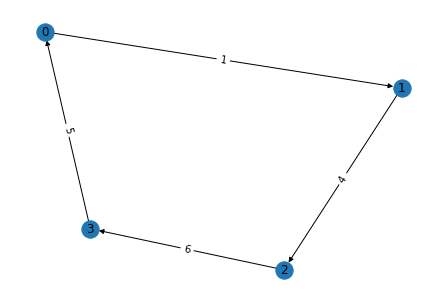

In [7]:
print("状態11000110は下の巡回路を表します。")
g = nx.DiGraph()
g.add_node(0)
g.add_node(1)
g.add_node(2)
g.add_node(3)
g.add_weighted_edges_from([
    (0, 1, 1),
    (1, 2, 4), 
    (2, 3, 6),
    (3, 0, 5) 
])

pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True)
labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
plt.show()
# 16

状態10001101は下の巡回路を表します。


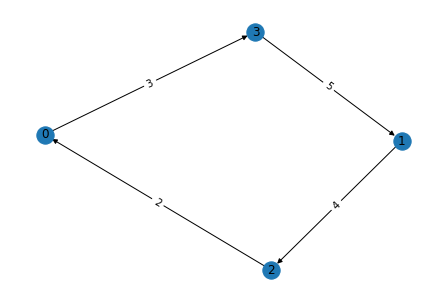

In [8]:
print("状態10001101は下の巡回路を表します。")
g = nx.DiGraph()
g.add_node(0)
g.add_node(1)
g.add_node(2)
g.add_node(3)
g.add_weighted_edges_from([
    (0, 3, 3),
    (3, 1, 5), 
    (1, 2, 4),
    (2, 0, 2) 
])

pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True)
labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
plt.show()
# 14

状態11001001は下の巡回路を表します。


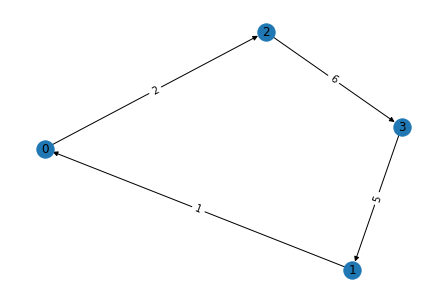

In [9]:
print("状態11001001は下の巡回路を表します。")
g = nx.DiGraph()
g.add_node(0)
g.add_node(1)
g.add_node(2)
g.add_node(3)
g.add_weighted_edges_from([
    (0, 2, 2),
    (2, 3, 6), 
    (3, 1, 5),
    (1, 0, 1) 
])

pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True)
labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
plt.show()
# 14

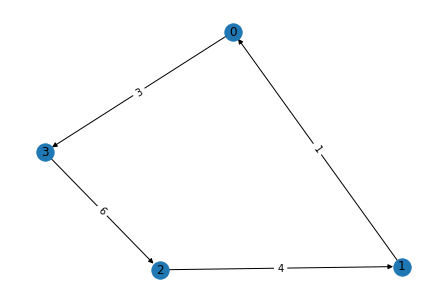

In [78]:
g = nx.DiGraph()
g.add_node(0)
g.add_node(1)
g.add_node(2)
g.add_node(3)
g.add_weighted_edges_from([
    (0, 3, 3),
    (3, 2, 6), 
    (2, 1, 4),
    (1, 0, 1) 
])

pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True)
labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
plt.show()